In [25]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

**Download the inception weights from**

https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


In [26]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [27]:
# Create an instance of the inception model from the local pre-trained weights
local_weights_file = 'C:/Users/OYO/Desktop/Tensorflow/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top=False,
                              weights=None)

pre_trained_model.load_weights(local_weights_file)

In [28]:
# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False

In [29]:
# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_94 (Batc (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_v1_94[0][0]  
_______________________________________________________________________________________

                                                                 activation_163[0][0]             
__________________________________________________________________________________________________
conv2d_166 (Conv2D)             (None, 7, 7, 192)    147456      mixed7[0][0]                     
__________________________________________________________________________________________________
batch_normalization_v1_166 (Bat (None, 7, 7, 192)    576         conv2d_166[0][0]                 
__________________________________________________________________________________________________
activation_166 (Activation)     (None, 7, 7, 192)    0           batch_normalization_v1_166[0][0] 
__________________________________________________________________________________________________
conv2d_167 (Conv2D)             (None, 7, 7, 192)    258048      activation_166[0][0]             
__________________________________________________________________________________________________
batch_norm

In [30]:
#Print last layer output
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [49]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
     def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.99): 
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

In [32]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024,activation="relu")(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1,activation="sigmoid")(x)        

model = Model(pre_trained_model.input,x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = "binary_crossentropy", 
              metrics = ['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_94 (Batc (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_v1_94[0][0]  
______________________________________________________________________________________________

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
path = 'C:/Users/OYO/Desktop/Tensorflow/cats_or_dogs/cats_and_dogs_filtered/'
#get to the cats and dogs directory

train_cats_dir = os.path.join(path,'train/cats')
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_dir = os.path.join(path,'train/dogs')
train_dogs_fnames = os.listdir(train_dogs_dir)

test_cats_dir = os.path.join(path,'validation/cats')
test_cats_fnames = os.listdir(test_cats_dir)
test_dogs_dir = os.path.join(path,'validation/dogs')
test_dogs_fnames = os.listdir(test_dogs_dir)

print(len(train_cats_fnames))
print(len(train_dogs_fnames))
print(len(test_cats_fnames))
print(len(test_dogs_fnames))

1000
1000
500
500


In [44]:
# Define our example directories and files
train_dir = os.path.join(path,'train/')
validation_dir = os.path.join(path,'validation/')

In [46]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1./255.)

In [47]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [51]:
# Run this and see how many epochs it should take before the callback

callbacks = myCallback()
history = model.fit_generator(train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2,
            callbacks=[callbacks])

Epoch 1/20
100/100 - 165s - loss: 0.3926 - acc: 0.8260 - val_loss: 0.1808 - val_acc: 0.9480
Epoch 2/20
100/100 - 175s - loss: 0.3454 - acc: 0.8505 - val_loss: 0.3410 - val_acc: 0.9350
Epoch 3/20
100/100 - 169s - loss: 0.3264 - acc: 0.8550 - val_loss: 0.2469 - val_acc: 0.9550
Epoch 4/20
100/100 - 182s - loss: 0.3374 - acc: 0.8570 - val_loss: 0.5533 - val_acc: 0.9240
Epoch 5/20
100/100 - 171s - loss: 0.3204 - acc: 0.8605 - val_loss: 0.3446 - val_acc: 0.9440
Epoch 6/20
100/100 - 172s - loss: 0.2925 - acc: 0.8795 - val_loss: 0.2643 - val_acc: 0.9610
Epoch 7/20
100/100 - 175s - loss: 0.3186 - acc: 0.8680 - val_loss: 0.4299 - val_acc: 0.9440
Epoch 8/20
100/100 - 184s - loss: 0.2876 - acc: 0.8900 - val_loss: 0.5848 - val_acc: 0.9330
Epoch 9/20
100/100 - 176s - loss: 0.2723 - acc: 0.8900 - val_loss: 0.3689 - val_acc: 0.9520
Epoch 10/20
100/100 - 173s - loss: 0.2866 - acc: 0.8775 - val_loss: 0.6075 - val_acc: 0.9310
Epoch 11/20
100/100 - 173s - loss: 0.2808 - acc: 0.8930 - val_loss: 0.4471 - va

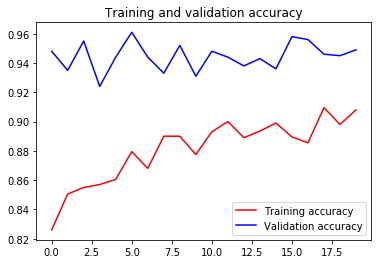

<Figure size 432x288 with 0 Axes>

In [53]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()